# Inverse folding with ESM-IF1

The ESM-IF1 inverse folding model is built for predicting protein sequences from their backbone atom coordinates. We provide examples here 1) to sample sequence designs for a given structure and 2) to score sequences for a given structure.

Trained with 12M protein structures predicted by AlphaFold2, the ESM-IF1 model consists of invariant geometric input processing layers followed by a sequence-to-sequence transformer, and achieves 51% native sequence recovery on structurally held-out backbones. The model is also trained with span masking to tolerate missing backbone coordinates and therefore can predict sequences for partially masked structures.

See [GitHub README](https://github.com/facebookresearch/esm/tree/main/examples/inverse_folding) for the complete user guide, and see our [bioRxiv pre-print](https://doi.org/10.1101/2022.04.10.487779) for more details.

## Environment setup (colab)
This step might take up to 10 minutes the first time. 

If using a local jupyter environment, instead of the following, we recommend configuring a conda environment upon first use in command line:
```
conda create -n inverse python=3.9
conda activate inverse
conda install pytorch cudatoolkit=11.3 -c pytorch
conda install pyg -c pyg -c conda-forge
conda install pip
pip install biotite
pip install git+https://github.com/facebookresearch/esm.git
```

Afterwards, `conda activate inverse` to activate this environment before starting `jupyter notebook`.

Below is the setup for colab notebooks:

We recommend using GPU runtimes on colab (Menu bar -> Runtime -> Change runtime type -> Hardware accelerator -> GPU)

In [1]:
# Colab environment setup

# Install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric

# Install esm
!pip install -q git+https://github.com/facebookresearch/esm.git

# Install biotite
!pip install -q biotite

     |████████████████████████████████| 7.9 MB 5.1 MB/s 
     |████████████████████████████████| 3.5 MB 3.9 MB/s 
     |████████████████████████████████| 2.4 MB 1.2 MB/s 
     |████████████████████████████████| 709 kB 4.0 MB/s 
     |████████████████████████████████| 407 kB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 31.8 MB 1.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


### Verify that pytorch-geometric is correctly installed

If the notebook crashes at the import, there is likely an issue with the version of torch_geometric and torch_sparse being incompatible with the torch version.

In [1]:
## Verify that pytorch-geometric is correctly installed
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing

## Load model
This steps takes a few minutes for the model to download.

**UPDATE**: It is important to set the model in eval mode through `model = model.eval()` to disable random dropout for optimal performance.

In [2]:
import esm
model, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
model = model.eval()

/home/gkannan/anaconda3/envs/inverse/lib/python3.9/site-packages/esm/pretrained.py:174: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


## Load structure from PDB or CIF files

As an example, let's look at Golgi Casein Kinase, the [PDB Molecule of the Month from January 2022](https://pdb101.rcsb.org/motm/265).

Milk is a complex mixture of proteins, fats, and nutrients that provides everything that a growing infant needs. Most of the protein in cow’s milk is casein, whereas human milk has lesser amounts of casein. 

The Golgi casein kinase (PDB entry 5YH2) adds phosphates to casein and also to many other types of secreted proteins. It is most active as a complex of two similar types of proteins. Fam20C is the catalytic subunit. It binds to casein and transfers a phosphate from ATP to the protein.

In this example, let's focus on chain C (the catalytic subunit Fam20C).

You may also upload your own CIF or PDB file and specify the chain id.

In [3]:
!wget https://files.rcsb.org/download/6M0J.pdb -P data/    # save this to the data folder in colab

--2022-07-13 19:45:43--  https://files.rcsb.org/download/6M0J.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.234
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘data/6M0J.pdb’

6M0J.pdb                [ <=>                ] 570.08K  --.-KB/s    in 0.09s   

2022-07-13 19:45:43 (6.25 MB/s) - ‘data/6M0J.pdb’ saved [583767]



Load chain C from this CIF file:

In [4]:
fpath = 'data/6M0J.pdb' # .pdb format is also acceptable
chain_id = 'E'
structure = esm.inverse_folding.util.load_structure(fpath, chain_id)
coords, native_seq = esm.inverse_folding.util.extract_coords_from_structure(structure)
print('Native sequence:')
print(native_seq)
print(len(native_seq))

Found 2 chains: ['A' 'E'] 

Loaded chain E

Native sequence:
TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG
194


Visualize chain C in this CIF file:

In [ ]:
!pip install -q py3Dmol

In [ ]:
try:
    import py3Dmol

    def view_pdb(fpath, chain_id):
        with open(fpath) as ifile:
            system = "".join([x for x in ifile])

        view = py3Dmol.view(width=600, height=400)
        view.addModelsAsFrames(system)
        view.setStyle({'model': -1, 'chain': chain_id}, {"cartoon": {'color': 'spectrum'}})
        view.zoomTo()
        view.show()

except ImportError:
    def view_pdb(fpath, chain_id):
        print("Install py3Dmol to visualize, or use pymol")

In [ ]:
view_pdb(fpath, chain_id)

Sample sequence and calculate sequence recovery:

In [5]:
import numpy as np

In [ ]:
import numpy as np

sampled_seq = model.sample(coords, temperature=1)
print('Sampled sequence:', sampled_seq)

recovery = np.mean([(a==b) for a, b in zip(native_seq, sampled_seq)])
print('Sequence recovery:', recovery)

In [ ]:
# Lower sampling temperature typically results in higher sequence recovery but less diversity

sampled_seq = model.sample(coords, temperature=1e-6)
print('Sampled sequence:', sampled_seq)

recovery = np.mean([(a==b) for a, b in zip(native_seq, sampled_seq)])
print('Sequence recovery:', recovery)

Sampled sequence: SCTILTKQAQLPLKYTDSYRHGIYYPENKFLSSTLVKVEDYYLPFHSKITHYRSEYISGENNTRVFETPVLPFKDGVFFAKMERSNVIRGFIFGSTLDESEPSFLFVEKANRIERSVCKFKFCDDPYLGVYHHSFDDTWSQEIFEIYTSKKDCTNEYVSEPYTSDLKEKTGNFTTLTIEIFKNENGFIKIYKKEIPINETDDLPEGFTALKPLESLPININITKFRVLNSLRTSYLIPGDDSTGWEADRAEYYVGYLEPRTRLLKYDSNGEITDSIDCDLDPLSEVKCKEFSFEVKEGIYEIDKFSEKPTETIIRRKDIKKICPFDEIFDAEKYASVFDYSKTKIENCVFDYSKLLSKKNFSYFKSYGIDPSLLNIMCFSNVYAYRFVIENYRVSEIAPGKTGVIADYNFRLPEDFKGTVIAWKADKKDTKFLGNFDYLYRKYADKKLKPFEKNTSTKIFEDGNTPCFGIEGENCYYPLETYDFKPYEDEKYQPVEVVILDYELLNSKAEVCGPNASTDTIEGKPVKVNLGNVTGEGKTTKCNGNNGKNCEYKTGNNTYPLSCYYPLGNNLYGIIYNPGGGVSYLIPSGKNFRLPEEGNSYYYGGNLRVKNITNNVYNGPVELNGNAEYSGGCSYPTLPLGNGISARYLKGNYAIYAYRNANGYNYSTNNNPNGYCYYYPLTYSEKPTETYNLYPNLTGNGTYPLIANLNGNCSNNGCNYNYNNCNNNGNNNYNNIYGYNPNGCYNYYPGNLYAYTFNNYYAYRFTINPYQVSNNNPGNGNNYANGCYRNNNGNGYYNNGNSNNNGNCYNGNPNDYYYRNGANSTLNGYQKNNCYYIYTDGNGNGGVVVGNGYYYPYNNNNFQPGYEVVIDYNGLNSPSYNLNGPGRGNNTNCNNNNINGNQGYYPYNNYNCNPGNNNGNGNNGYNNNYNYNNQNNYNCNNNNINNNYNGNCCYYPLSGNNIGPNQPGNNCYYPNGNCNYNG

## Conditional sequence log-likelihoods for given backbone coordinates

The log-likelihood scores could be used to predict mutational effects. See also our [script](https://github.com/facebookresearch/esm/tree/main/examples/inverse_folding#scoring-sequences) for batch scoring,

In [6]:
#Calculating all possible mutants in protein
#N501Y mutated below (TNGV -> TYGV)

wuhan = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
alpha = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'
delta = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'

chosenseq = delta
seq = list(chosenseq)
aalist = ["A","R","N","D","C","E","Q","G","H","I","L","K","M","F","P","S","T","W","Y","V"]

seq2 = seq.copy()
muts = {'WT': "".join(seq)}
for i in range(0,len(seq)):
  for j in aalist:
    seq2[i] = j
    muts.update({str(i)+j:"".join(seq2)})
    seq2 = seq.copy()


In [7]:
output_path = 'data/all_mutant_list_delta.txt'
output_file = open(output_path,'w')

for seq_id, sequence in muts.items():
    identifier_line = ">" + seq_id + "\n"
    output_file.write(identifier_line)
    sequence_line = sequence + "\n"
    output_file.write(sequence_line)
    
#Close the file when we're done
output_file.close()

In [8]:
ll_fullseq, ll_withcoord = esm.inverse_folding.util.score_sequence(model, alphabet, coords, native_seq)

print(f'average log-likelihood on entire sequence: {ll_fullseq:.2f} (perplexity {np.exp(-ll_fullseq):.2f})')
print(f'average log-likelihood excluding missing coordinates: {ll_withcoord:.2f} (perplexity {np.exp(-ll_withcoord):.2f})')

average log-likelihood on entire sequence: -1.20 (perplexity 3.30)
average log-likelihood excluding missing coordinates: -1.20 (perplexity 3.30)


Make sure to change both all_mutant_list_X and all_mutant_list_lls_X to the variant X!

In [ ]:
!python score_log_likelihoods.py data/6M0J.pdb \
    data/all_mutant_list_delta.txt --chain E \
    --outpath output/mutant_list_lls_delta.csv

In [ ]:
seq[168]

'N'

In [ ]:
len('TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG')

194

## Masking part of the backbone coordinates
To partially mask backbone coordinates, simply set the masked coordinates to np.inf. 

Typically, the sequence perplexity will be higher on masked regions than on unmasked regions.

In [ ]:
from copy import deepcopy
masked_coords = deepcopy(coords)
masked_coords[:15] = np.inf # mask the first 10 residues
ll_fullseq, ll_withcoord = esm.inverse_folding.util.score_sequence(model, alphabet, masked_coords, native_seq)

print(f'average log-likelihood on entire sequence: {ll_fullseq:.2f} (perplexity {np.exp(-ll_fullseq):.2f})')
print(f'average log-likelihood excluding missing coordinates: {ll_withcoord:.2f} (perplexity {np.exp(-ll_withcoord):.2f})')

## Extract encoder output as structure representation
The encoder output may also be used as a representation for the structure.

For a set of input coordinates with L amino acids, the encoder output will have shape L x 512.

In [ ]:
rep = esm.inverse_folding.util.get_encoder_output(model, alphabet, coords)
len(coords), rep.shape

# Analysis

In [1]:
#Read in data, make new dataframes

import pandas as pd
import numpy as np

aalist = ["A","R","N","D","C","E","Q","G","H","I","L","K","M","F","P","S","T","W","Y","V"]

all_mutants_df=pd.read_table("data/all_mutant_list.txt", sep=" ", header=None)
all_mutants_N501Y_df=data=pd.read_table("data/all_mutant_list_N501Y.txt", sep=" ", header=None)
all_mutants_df.insert(1,'sequence','')
all_mutants_N501Y_df.insert(1,'sequence','')
all_mutants_delta_df=pd.read_table("data/all_mutant_list_delta.txt", sep=" ", header=None)
all_mutants_delta_df.insert(1,'sequence','')

mutants_df = pd.DataFrame({'mutation':all_mutants_df[0].iloc[::2].values, 'sequence':all_mutants_df[0].iloc[1::2].values})
N501Y_df = pd.DataFrame({'mutation':all_mutants_N501Y_df[0].iloc[::2].values, 'sequence':all_mutants_N501Y_df[0].iloc[1::2].values})
delta_df = pd.DataFrame({'mutation':all_mutants_delta_df[0].iloc[::2].values, 'sequence':all_mutants_delta_df[0].iloc[1::2].values})

mlistll=pd.read_csv("data/mutant_list_lls.csv", sep=",", header=0)
mlistN501Yll=data=pd.read_csv("data/mutant_list_lls_N501Y.csv", sep=",", header=0)
mlistdeltall=data=pd.read_csv("data/mutant_list_lls_delta.csv", sep=",", header=0)

In [2]:
#Add likelihoods to main dataframes, and normalize

mutants_df['log likelihood'] = mlistll['log_likelihood']
N501Y_df['log likelihood'] = mlistN501Yll['log_likelihood']
delta_df['log likelihood'] = mlistdeltall['log_likelihood']

mutants_df['likelihood'] = np.exp(mutants_df['log likelihood']) -np.exp(-1.1953586339950562)
N501Y_df['likelihood'] = np.exp(N501Y_df['log likelihood']) -np.exp(-1.2073875665664673)
delta_df['likelihood'] = np.exp(delta_df['log likelihood']) -np.exp(-1.2177070379257202)

In [3]:
#Normalize and get the difference

N501Y_df['ll_ratio'] = (N501Y_df['log likelihood'] - -1.2073875665664673) - (mutants_df['log likelihood'] - -1.1953586339950562)
delta_df['ll_ratio'] = (delta_df['log likelihood'] - -1.2177070379257202) - (mutants_df['log likelihood'] - -1.1953586339950562)

#(np.exp(N501Y_df['log likelihood'])/(np.exp(-1.2073875665664673)))-(np.exp(mutants_df['log likelihood'])/np.exp(-1.1953586339950562))

#(np.exp(N501Y_df['log likelihood'])/np.exp(-1.2073875665664673)) - mutants_df['log likelihood'] - -1.1953586339950562



<AxesSubplot:>

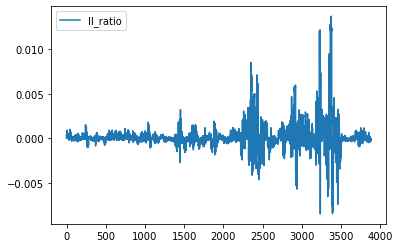

In [4]:
delta_df.plot(y='ll_ratio')

In [5]:
N501Y_df['mutation'] = N501Y_df['mutation'].map(lambda x: x.lstrip('>'))
mutants_df['mutation'] = mutants_df['mutation'].map(lambda x: x.lstrip('>'))
delta_df['mutation'] = delta_df['mutation'].map(lambda x: x.lstrip('>'))


In [6]:
N501Y_df['index']=N501Y_df['mutation']
mutants_df['index']=mutants_df['mutation']

delta_df['index']=delta_df['mutation']

In [7]:
N501Y_df_noWT = N501Y_df.copy()
N501Y_df_noWT = N501Y_df_noWT.iloc[1: , :]

mutants_df_noWT = mutants_df.copy()
mutants_df_noWT = mutants_df_noWT.iloc[1: , :]

delta_df_noWT = delta_df.copy()
delta_df_noWT = delta_df_noWT.iloc[1: , :]

In [8]:
N501Y_df_noWT['mutation'] = N501Y_df_noWT['mutation'].str.replace('\d+', '')
N501Y_df_noWT['index'] = N501Y_df_noWT['index'].str.replace(str(aalist), '')

mutants_df_noWT['mutation'] = mutants_df_noWT['mutation'].str.replace('\d+', '')
mutants_df_noWT['index'] = mutants_df_noWT['index'].str.replace(str(aalist), '')

delta_df_noWT['mutation'] = delta_df_noWT['mutation'].str.replace('\d+', '')
delta_df_noWT['index'] = delta_df_noWT['index'].str.replace(str(aalist), '')

/tmp/ipykernel_2773157/3592318787.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  N501Y_df_noWT['mutation'] = N501Y_df_noWT['mutation'].str.replace('\d+', '')
/tmp/ipykernel_2773157/3592318787.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  N501Y_df_noWT['index'] = N501Y_df_noWT['index'].str.replace(str(aalist), '')
/tmp/ipykernel_2773157/3592318787.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  mutants_df_noWT['mutation'] = mutants_df_noWT['mutation'].str.replace('\d+', '')
/tmp/ipykernel_2773157/3592318787.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  mutants_df_noWT['index'] = mutants_df_noWT['index'].str.replace(str(aalist), '')
/tmp/ipykernel_2773157/3592318787.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  delt

In [9]:
N501Y_df_noWT['index'] = pd.to_numeric(N501Y_df_noWT['index'])
N501Y_df_noWT['index'] = N501Y_df_noWT['index'] + 333

delta_df_noWT['index'] = pd.to_numeric(delta_df_noWT['index'])
delta_df_noWT['index'] = delta_df_noWT['index'] + 333

result = N501Y_df_noWT.pivot_table(index='mutation', columns='index', values='ll_ratio',sort=False)

mutants_df_noWT['index'] = pd.to_numeric(mutants_df_noWT['index'])
mutants_df_noWT['index'] = mutants_df_noWT['index'] + 333

result_mut = mutants_df_noWT.pivot_table(index='mutation', columns='index', values='likelihood',sort=False)

result_N501Y = N501Y_df_noWT.pivot_table(index='mutation', columns='index', values='likelihood',sort=False)

result_delta = delta_df_noWT.pivot_table(index='mutation', columns='index', values='ll_ratio',sort=False)

result_delta_only = delta_df_noWT.pivot_table(index='mutation', columns='index', values='likelihood',sort=False)

In [10]:
result_delta.to_excel('result_delta.xlsx')

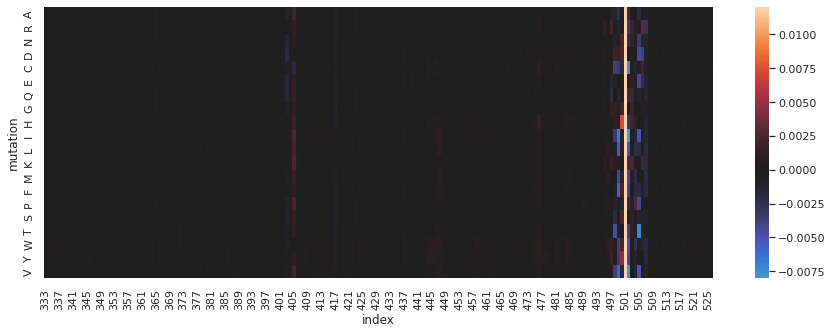

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result, annot=False, cmap='icefire',center=0)
plt.show()

#N501Y

<AxesSubplot:xlabel='index'>

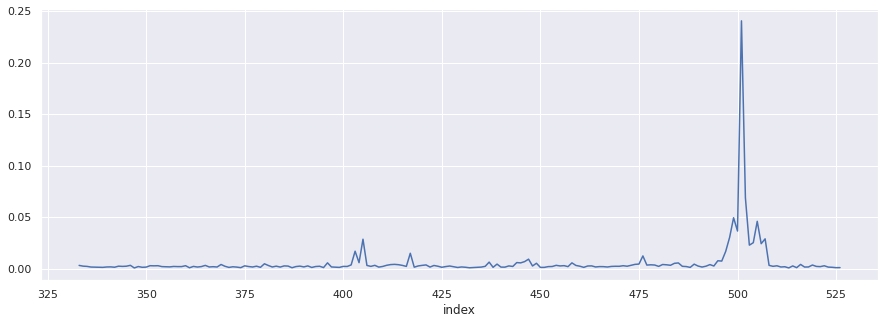

In [12]:
result_abs = abs(result)
resultsum = result_abs.sum()
resultsum.plot()

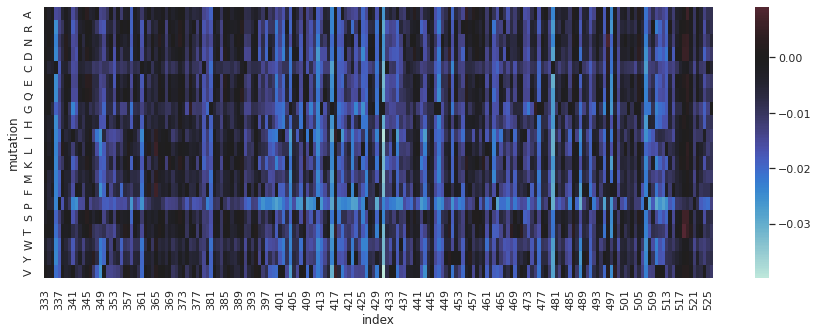

In [13]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_mut, annot=False, cmap='icefire',center=0)
plt.show()
#Wuhan

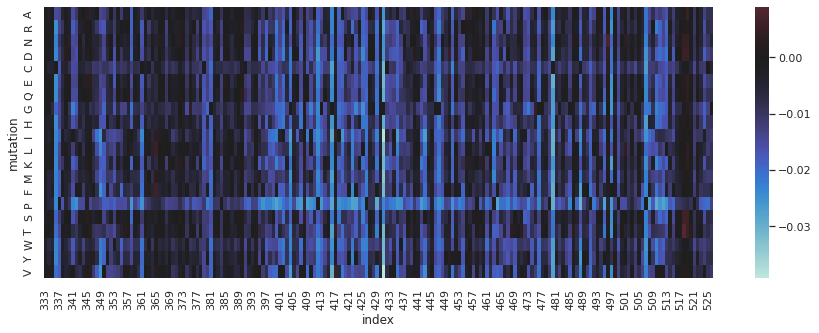

In [14]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_N501Y, annot=False, cmap='icefire',center=0)
plt.show()
#N501Y

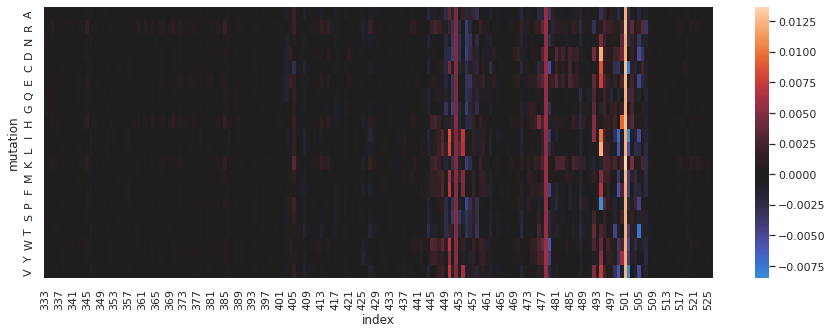

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_delta, annot=False, cmap='icefire',center=0)
plt.show()

#Delta

<AxesSubplot:xlabel='index'>

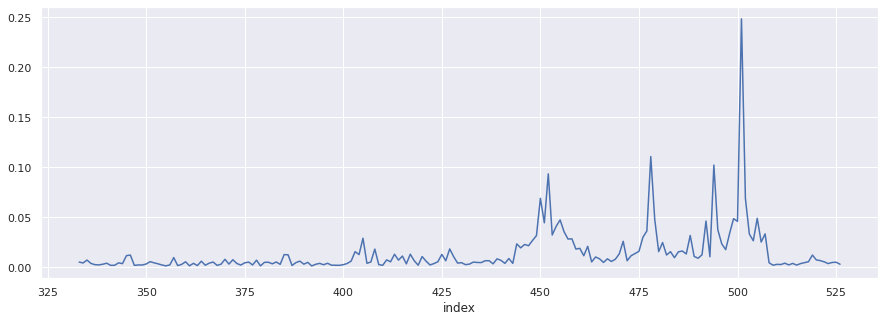

In [16]:
result_delta_abs = abs(result_delta)
resultdeltasum = result_delta_abs.sum()
resultdeltasum.plot()

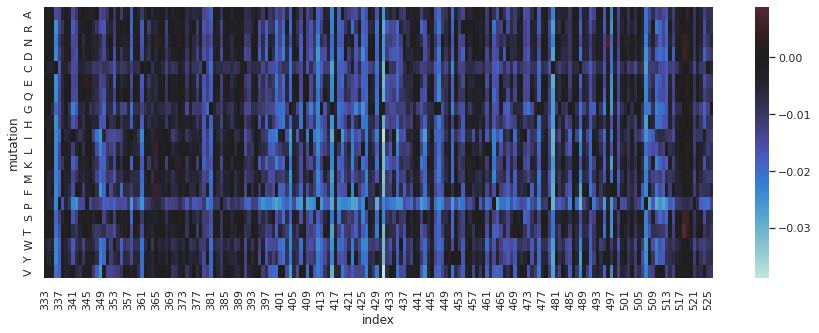

In [17]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_delta_only, annot=False, cmap='icefire',center=0)
plt.show()
#Delta

In [18]:
#Let's try a Spearman correlation with the JB expression data.

#First, let's import the data and separate it into dataframes for each variant.

jb_df = pd.read_csv('data/bloom_science_expr.csv')

In [19]:
#create unique list of names
VariantNames = jb_df.target.unique()

#create a data frame dictionary to store your data frames
bloom_data = {elem : pd.DataFrame() for elem in VariantNames}

for key in bloom_data.keys():
    bloom_data[key] = jb_df[:][jb_df.target == key]

In [122]:
#Pivot table to get each variant
bloom_N501Y = bloom_data['N501Y'].pivot_table(index='mutant', columns='position', values='delta_expr',sort=False)
bloom_wuhan = bloom_data['Wuhan-Hu-1'].pivot_table(index='mutant', columns='position', values='delta_expr',sort=False)
bloom_delta = bloom_data['Delta'].pivot_table(index='mutant', columns='position', values='delta_expr',sort=False)

#Drop the first two columns and last five columns; these are cut out in the native sequence for esm-if1.
bloom_N501Y = bloom_N501Y.iloc[: , 2:196]
bloom_wuhan = bloom_wuhan.iloc[: , 2:196]
bloom_delta = bloom_delta.iloc[: , 2:196]

#Same thing but for ACE2 binding
bloom_N501Y_bind = bloom_data['N501Y'].pivot_table(index='mutant', columns='position', values='delta_bind',sort=False)
bloom_wuhan_bind = bloom_data['Wuhan-Hu-1'].pivot_table(index='mutant', columns='position', values='delta_bind',sort=False)
bloom_delta_bind = bloom_data['Delta'].pivot_table(index='mutant', columns='position', values='delta_bind',sort=False)

#Drop the first two columns and last five columns; these are cut out in the native sequence for esm-if1.
bloom_N501Y_bind = bloom_N501Y_bind.iloc[: , 2:196]
bloom_wuhan_bind = bloom_wuhan_bind.iloc[: , 2:196]
bloom_delta_bind = bloom_delta_bind.iloc[: , 2:196]


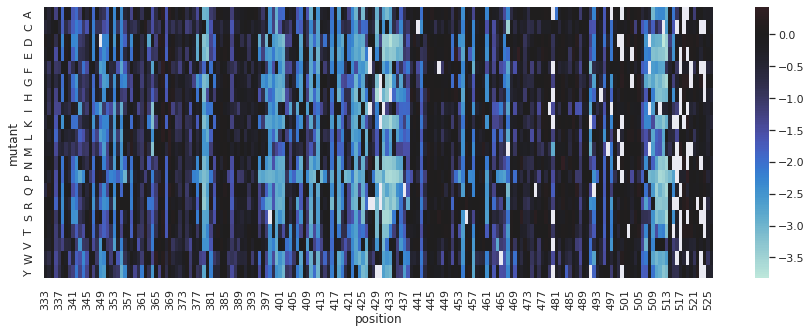

In [21]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(bloom_wuhan, annot=False, cmap='icefire',center=0)
plt.show()
#wuhan

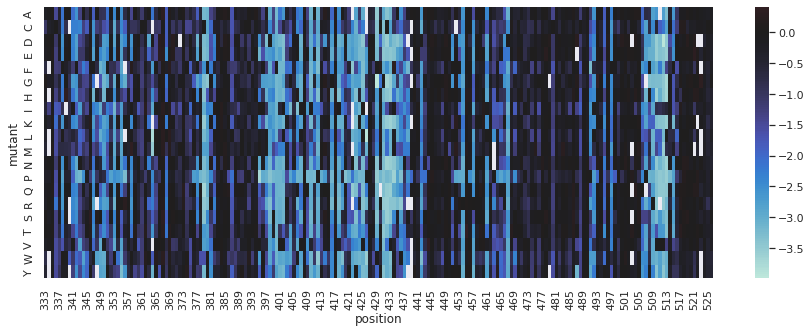

In [22]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(bloom_N501Y, annot=False, cmap='icefire',center=0)
plt.show()
#N501Y

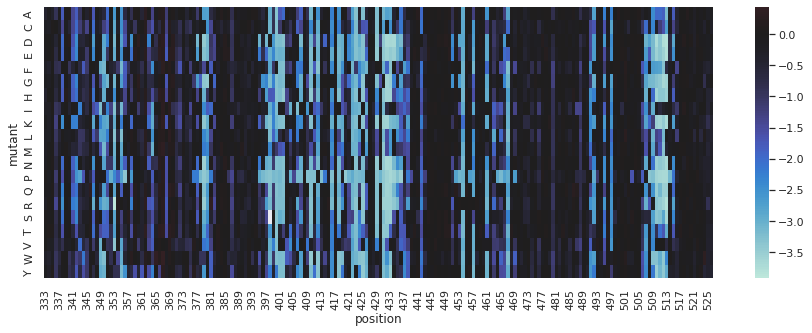

In [23]:
sns.set(rc = {'figure.figsize':(15,5)})

cmaptest = sns.diverging_palette(240, 0, s=100, sep=1 ,l=70, center='dark',as_cmap=True)

sns.heatmap(bloom_delta, annot=False, cmap='icefire',center=0)
plt.show()
#delta

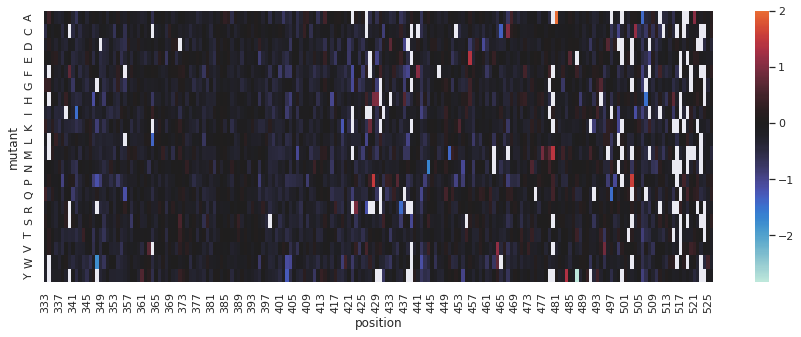

In [24]:
#Wrong comp but roughly similar

bloom_comp = bloom_N501Y - bloom_wuhan

sns.heatmap(bloom_comp, annot=False, cmap='icefire',center=0)
plt.show()

<AxesSubplot:xlabel='position'>

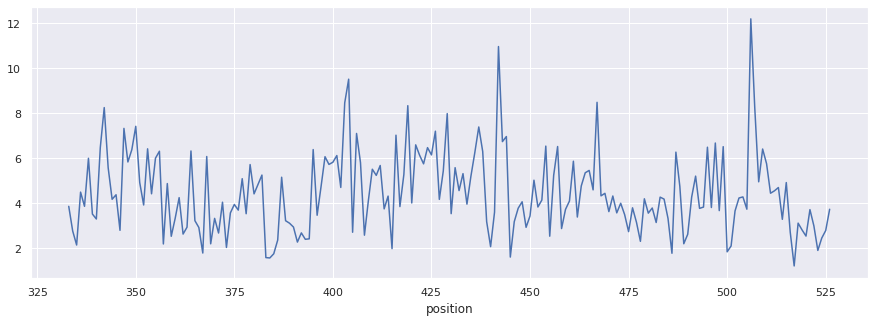

In [25]:
bloom_comp_abs = abs(bloom_comp)
bloom_comp_sum = bloom_comp_abs.sum()
bloom_comp_sum.plot()

In [26]:
#Now to actually try a spearman correlation; we need to put all the bloom delta expression and my data in one column each.

N501Y_df_noWT_rn = N501Y_df_noWT.copy()
N501Y_df_noWT_rn = N501Y_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})
N501Y_merged_df = N501Y_df_noWT_rn.merge(bloom_data['N501Y'],on = ['position', 'mutant'], how = 'left')



In [30]:
delta_df_noWT_rn = delta_df_noWT.copy()
delta_df_noWT_rn = delta_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})
delta_merged_df = delta_df_noWT_rn.merge(bloom_data['Delta'],on = ['position', 'mutant'], how = 'left')


In [31]:
#Now the actual spearman correlation

corr_columns_N501Y = N501Y_merged_df[['likelihood','delta_expr']]

corr_columns_delta = delta_merged_df[['likelihood','expr']]


In [32]:
corr_columns_N501Y.corr(method='spearman')

,likelihood,delta_expr
likelihood,1.000000,0.693525
delta_expr,0.693525,1.000000


<AxesSubplot:xlabel='likelihood'>

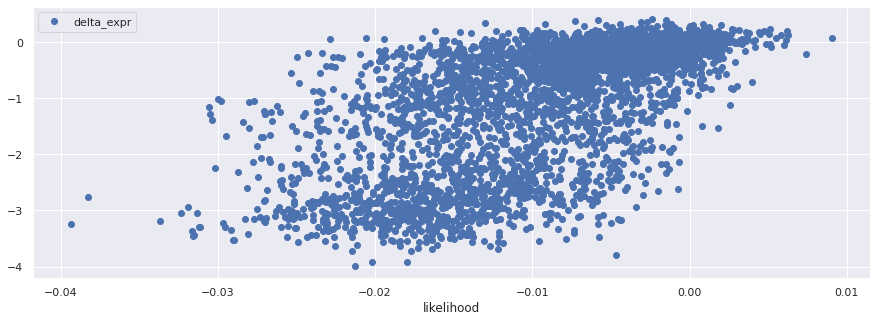

In [33]:
corr_columns_N501Y.plot(x='likelihood',y='delta_expr',style='o')

In [34]:
corr_columns_delta.corr(method='spearman')

,likelihood,expr
likelihood,1.00000,0.65381
expr,0.65381,1.00000


<AxesSubplot:xlabel='likelihood'>

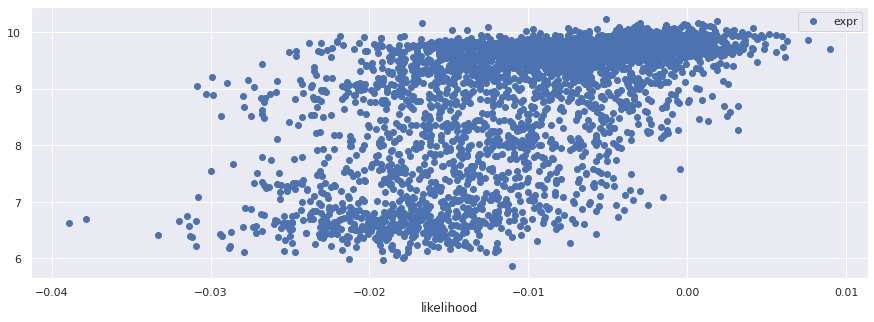

In [35]:
corr_columns_delta.plot(x='likelihood',y='expr',style='o')

In [36]:
corr_columns_N501Y_bind = N501Y_merged_df[['likelihood','bind']]
corr_columns_N501Y_bind.corr(method='spearman')

,likelihood,bind
likelihood,1.000000,0.640286
bind,0.640286,1.000000


In [37]:
corr_columns_delta_bind = delta_merged_df[['likelihood','bind']]
corr_columns_delta_bind.corr(method='spearman')

,likelihood,bind
likelihood,1.000000,0.621878
bind,0.621878,1.000000


In [38]:
bloom_data_N501Y_expr = bloom_data['N501Y'][['position','mutant','expr']]
bloom_data_N501Y_expr['expr_ratio'] = np.log(bloom_data['N501Y']['expr'].to_numpy()/10.14430) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)


/tmp/ipykernel_2773157/3181289053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bloom_data_N501Y_expr['expr_ratio'] = np.log(bloom_data['N501Y']['expr'].to_numpy()/10.14430) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)


In [39]:
bloom_data_N501Y_expr

,position,mutant,expr,expr_ratio
8040,331,A,NaN,NaN
8041,331,C,9.58908,-0.005000
8042,331,D,10.07589,0.004690
8043,331,E,10.13296,-0.000969
8044,331,F,9.52710,-0.045750
...,...,...,...,...
12055,531,S,NaN,NaN
12056,531,T,10.14430,0.000000
12057,531,V,10.20020,-0.007105
12058,531,W,10.16400,0.001480


In [40]:
N501Y_df_noWT_rn = N501Y_df_noWT.copy()
N501Y_df_noWT_rn = N501Y_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})
N501Y_merged_df = N501Y_df_noWT_rn.merge(bloom_data_N501Y_expr,on = ['position', 'mutant'], how = 'left')

In [41]:
corr_columns_N501Y_expr_ratio = N501Y_merged_df[['ll_ratio','expr_ratio']]
corr_columns_N501Y_expr_ratio.corr(method='spearman')

,ll_ratio,expr_ratio
ll_ratio,1.000000,0.008528
expr_ratio,0.008528,1.000000


<AxesSubplot:xlabel='ll_ratio'>

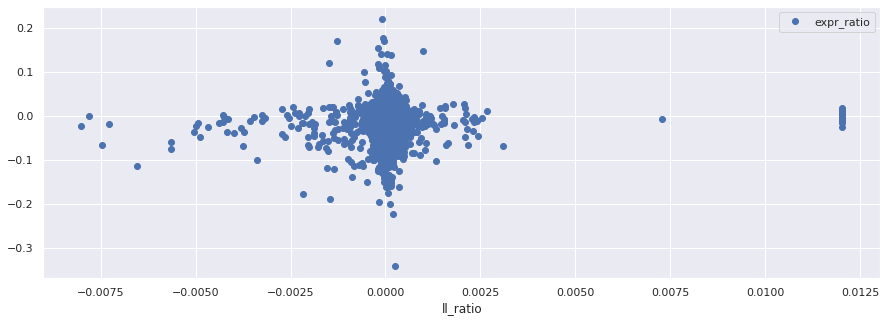

In [42]:
corr_columns_N501Y_expr_ratio.plot(x='ll_ratio',y='expr_ratio',style='o')

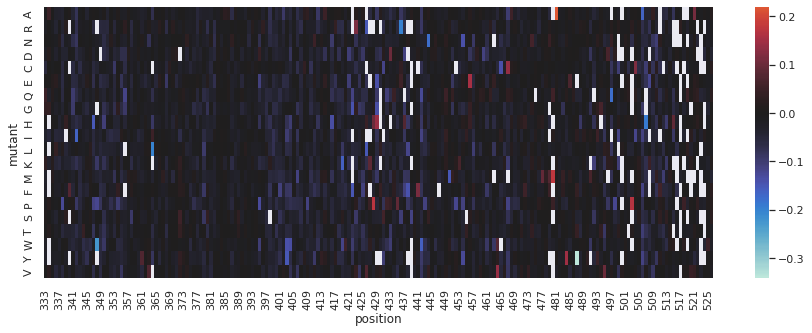

In [43]:
#Actual comp for N501Y

bloom_pivot_N501Y = N501Y_merged_df.pivot_table(index='mutant', columns='position', values='expr_ratio',sort=False)

sns.heatmap(bloom_pivot_N501Y, annot=False, cmap='icefire',center=0)
plt.show()


<AxesSubplot:xlabel='position'>

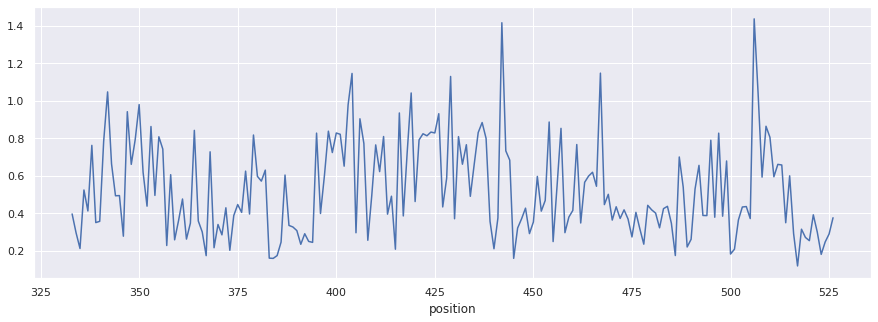

In [44]:
bloom_pivot_N501Y_abs = abs(bloom_pivot_N501Y)
bloom_pivot_N501Y_sum = bloom_pivot_N501Y_abs.sum()
bloom_pivot_N501Y_sum.plot()

In [45]:
bloom_data_Delta_expr = bloom_data['Delta'][['position','mutant','expr']]
bloom_data_Delta_expr['expr_ratio'] = np.log(bloom_data['Delta']['expr'].to_numpy()/9.79026) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)

delta_df_noWT_rn = delta_df_noWT_rn.copy()
delta_df_noWT_rn = delta_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})
Delta_merged_df = delta_df_noWT_rn.merge(bloom_data_Delta_expr,on = ['position', 'mutant'], how = 'left')

corr_columns_Delta_expr_ratio = Delta_merged_df[['ll_ratio','expr_ratio']]
corr_columns_Delta_expr_ratio.corr(method='spearman')

/tmp/ipykernel_2773157/1840232851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bloom_data_Delta_expr['expr_ratio'] = np.log(bloom_data['Delta']['expr'].to_numpy()/9.79026) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)


,ll_ratio,expr_ratio
ll_ratio,1.000000,0.041724
expr_ratio,0.041724,1.000000


So now I want to try jensen shannon divergence

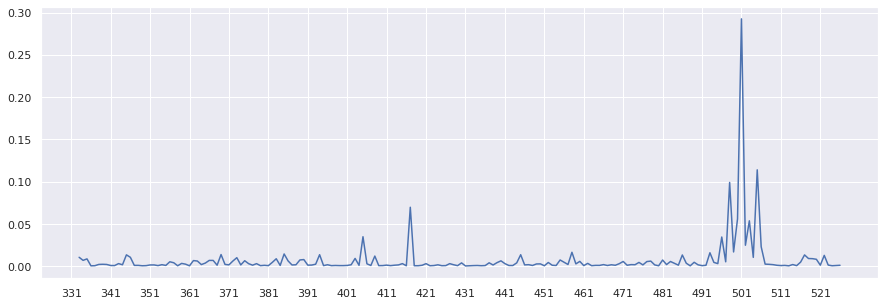

In [144]:
#Cycle through all positions, calculate JSD between results_N501Y and result_mutant at each position

#You want JSD between pairs of columns.

import scipy

jsd_N501Y = []
columns = []

for column in result_N501Y:
    columns.append(column)
    jsd_N501Y.append(scipy.spatial.distance.jensenshannon(result_N501Y[column],result_mut[column]))
    
plt.plot(columns,scipy.spatial.distance.jensenshannon(abs(result_N501Y),abs(result_mut),axis=0))

freq_x = 10

plt.xticks(np.arange(331, 531, freq_x))
plt.show()

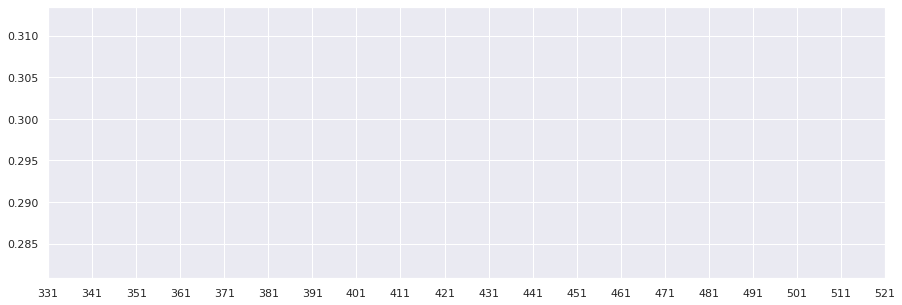

In [139]:
plt.plot(columns,scipy.spatial.distance.jensenshannon(result,bloom_pivot_N501Y,axis=0))

freq_x = 10

plt.xticks(np.arange(331, 531, freq_x))
plt.show()